# Tutorial :   Exploring regression on Spatial Data


## Overview

In this tutorial, we will explore some applications of data science on spatial data using R language.

Specifically, we will use:

-	**Variogram** to study spatial dependency between spatial data frame
-	**Kriging** and **Simulation** to interpolate properties values in a spatial data frame.

Those technics are used a lot in mining area for resource estimation.

This tutorial introduced the functionality of the R package **gstat**, used in conjunction with package **sp**.

Package **gstat** provides a wide range of univariable and multivariable geostatistical modelling, prediction and simulation functions, where package **sp** provides general purpose classes and methods for defining, importing/exporting and visualizing spatial data.

Other geostatistical packages for R exists e.g., packages **geoR** and **geoRglm**.


For our example, we will work with heavy metal pollution data, sampled from the delta of the Meuse River in Belgium. 
The **meuse data** set provided by package sp is a data set comprising of four heavy metals measured in the top soil in a flood plain along the river Meuse, along with a handful of covariates. The process governing heavy metal distribution seems that polluted sediment is carried by the river, and mostly deposited close to the river bank, and areas with low elevation. This document shows a geostatistical analysis of this data set. The data set was introduced by Burrough and McDonnell, 1998

The values of metal concentrations are sampled at certain spatial points. The spatial sampling is not performed on a close-spaced regular grid. Therefore, spatial interpolation is used to create a map of the expected concentration of metal pollution. Specifically, we will:

-	Load and examine the properties of these data.
-	Explore the spatial dependency using the **variogram** of the metal pollution data.
-	Use **kriging** and **simulation** to interpolate and create a map of metal pollution.





## Data loading, exploration and conversion

In [29]:
#install.packages("sp")
library(sp)
data(meuse)
names(meuse)
head(meuse)

[1] "x"       "y"       "cadmium" "copper"  "lead"    "zinc"    "elev"   
 [8] "dist"    "om"      "ffreq"   "soil"    "lime"    "landuse" "dist.m"

x,y,cadmium,copper,lead,zinc,elev,dist,om,ffreq,soil,lime,landuse,dist.m
181072,333611,11.7,85,299,1022,7.909,0.00135803,13.6,1,1,1,Ah,50
181025,333558,8.6,81,277,1141,6.983,0.01222430,14.0,1,1,1,Ah,30
181165,333537,6.5,68,199,640,7.800,0.10302900,13.0,1,1,1,Ah,150
181298,333484,2.6,81,116,257,7.655,0.19009400,8.0,1,2,0,Ga,270
181307,333330,2.8,48,117,269,7.480,0.27709000,8.7,1,2,0,Ah,380
181390,333260,3.0,61,137,281,7.791,0.36406700,7.8,1,2,0,Ga,470


The **meuse** data frame has the columns shown above. In particular, note the **x** and **y** columns that indicate location, and columns with the names of the metals. 

Next, find the class of the **meuse** data frame, by exectuing the code in the cell below.

In [30]:
class(meuse)

[1] "data.frame"

The **meuse** data frame is an ordinary data frame. 

The code below converts the ordinary data frame to a spatial data frame, in two steps. The first adds a **coordinates** attribute to the data frame. The second step adds a projection string to the data frame. 

Execute the code in the cell below to convert the **meuse** data frame to a spatial data frame.

In [31]:
set.coords = function(df){
  require(sp)
  # Function converts dataframe to spatialpointsdataframe
  # Convert to spatial points data frame
  coordinates(df) = ~x+y 

  # Assign the datum and compute the lat-lon of the 
  # of the x-y coordinates
  proj4string(df) <- CRS("+proj=stere
   +lat_0=52.15616055555555 +lon_0=5.38763888888889
   +k=0.999908 +x_0=155000 +y_0=463000
   +ellps=bessel +units=m +no_defs
   +towgs84=565.2369,50.0087,465.658,
   -0.406857330322398,0.350732676542563,-1.8703473836068, 4.0812")
  df
}
meuse = set.coords(meuse)

With the spatial attributed added, the **meuse** data frame is now of class **SpatialPointsDataFrame**.

To view a summary of this data frame, execute the code in the cell below. 

In [32]:
summary(meuse)

Object of class SpatialPointsDataFrame
Coordinates:
     min    max
x 178605 181390
y 329714 333611
Is projected: TRUE 
proj4string :
[+proj=stere +lat_0=52.15616055555555 +lon_0=5.38763888888889
+k=0.999908 +x_0=155000 +y_0=463000 +ellps=bessel +units=m +no_defs
+towgs84=565.2369,50.0087,465.658,
-0.406857330322398,0.350732676542563,-1.8703473836068, 4.0812]
Number of points: 155
Data attributes:
    cadmium           copper            lead            zinc       
 Min.   : 0.200   Min.   : 14.00   Min.   : 37.0   Min.   : 113.0  
 1st Qu.: 0.800   1st Qu.: 23.00   1st Qu.: 72.5   1st Qu.: 198.0  
 Median : 2.100   Median : 31.00   Median :123.0   Median : 326.0  
 Mean   : 3.246   Mean   : 40.32   Mean   :153.4   Mean   : 469.7  
 3rd Qu.: 3.850   3rd Qu.: 49.50   3rd Qu.:207.0   3rd Qu.: 674.5  
 Max.   :18.100   Max.   :128.00   Max.   :654.0   Max.   :1839.0  
                                                                   
      elev             dist               om         ff

Examine this summary noting the following:

- The coordinates of the points are now attributes of the data frame, along with the projection string.
- There are 4 columns showing the concentration of heavy metals at the spatial sample points.
- Other values in the data frame include **dist** giving the distance to the Meuse River.

## Loading the Grid Data

In order to interpolate the metal polution data to a grid, you must supply a spatial grid to interpolate to. The **meuse.grid** data frame contains just such a grid. Execute the code in the cell below to load the grid data and examine its class. 

In [33]:
data(meuse.grid)
class(meuse.grid)

[1] "data.frame"

This data frame must be converted to a spatial data frame class. The code below performs two operations. First, the **set.coords** function is used again to add coordinate attributes to the data frame, creating a spatial data frame. Second, since the points are on a regular grid, the gridded attribute is set to TRUE.

Execute the code in the cell below to create a SpatialPixelsDataFrame.

In [34]:
meuse.grid = set.coords(meuse.grid)
gridded(meuse.grid) = TRUE

A SpatialPixelsDataFrame is distigushed by having the spatial cordinates at the center of a 'pixel'. 

Execute the code in the cell below to produce a summary of the SpatialPixelsDataFrame. 

In [35]:
summary(meuse.grid)

Object of class SpatialPixelsDataFrame
Coordinates:
     min    max
x 178440 181560
y 329600 333760
Is projected: TRUE 
proj4string :
[+proj=stere +lat_0=52.15616055555555 +lon_0=5.38763888888889
+k=0.999908 +x_0=155000 +y_0=463000 +ellps=bessel +units=m +no_defs
+towgs84=565.2369,50.0087,465.658,
-0.406857330322398,0.350732676542563,-1.8703473836068, 4.0812]
Number of points: 3103
Grid attributes:
  cellcentre.offset cellsize cells.dim
x            178460       40        78
y            329620       40       104
Data attributes:
     part.a           part.b            dist        soil     ffreq   
 Min.   :0.0000   Min.   :0.0000   Min.   :0.0000   1:1665   1: 779  
 1st Qu.:0.0000   1st Qu.:0.0000   1st Qu.:0.1193   2:1084   2:1335  
 Median :0.0000   Median :1.0000   Median :0.2715   3: 354   3: 989  
 Mean   :0.3986   Mean   :0.6014   Mean   :0.2971                    
 3rd Qu.:1.0000   3rd Qu.:1.0000   3rd Qu.:0.4402                    
 Max.   :1.0000   Max.   :1.0000   Max.   :0

The SpatialPixelDataFrame has the same coordinate attributes seen in the **meuse** data frame. This SpatialPixelDataFrame contains some other columns which are shown. 

## Plot the Metal Concentration

Now that you have loaded and examined the data set, you will create spatial maps of the sampled concentrations of the metals. The code below uses a bubble plot, where the size of the bubble corresponds to a numeric value. 

Unit is in Parts Per Million (ppm) which is a measurement of the concentration of a solution

Execute the code in the cell below to plot the spatial concentration of each of the metals.

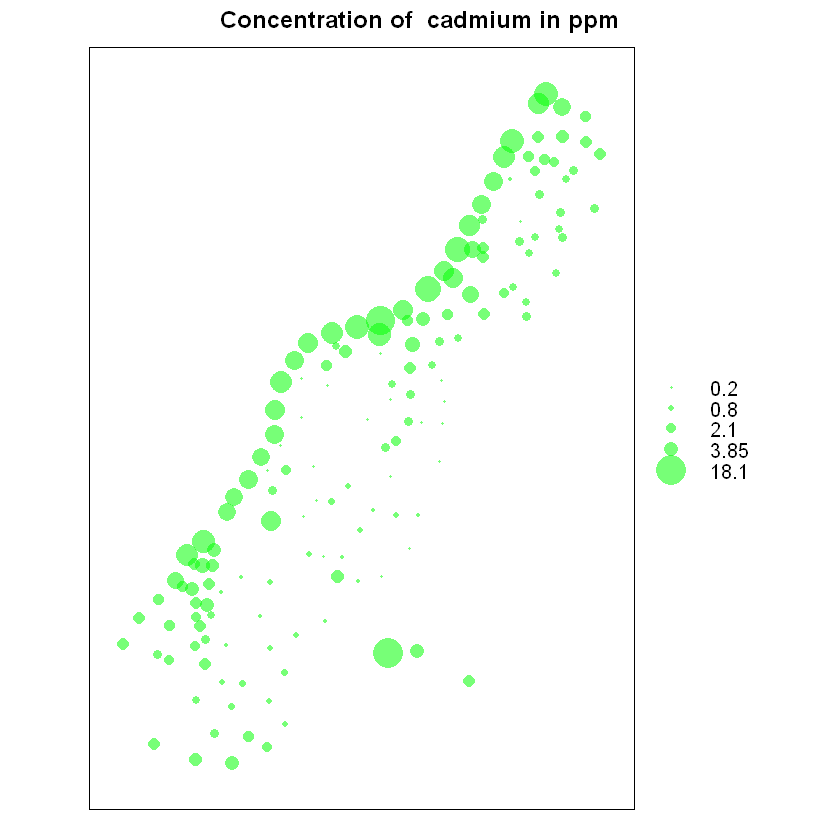

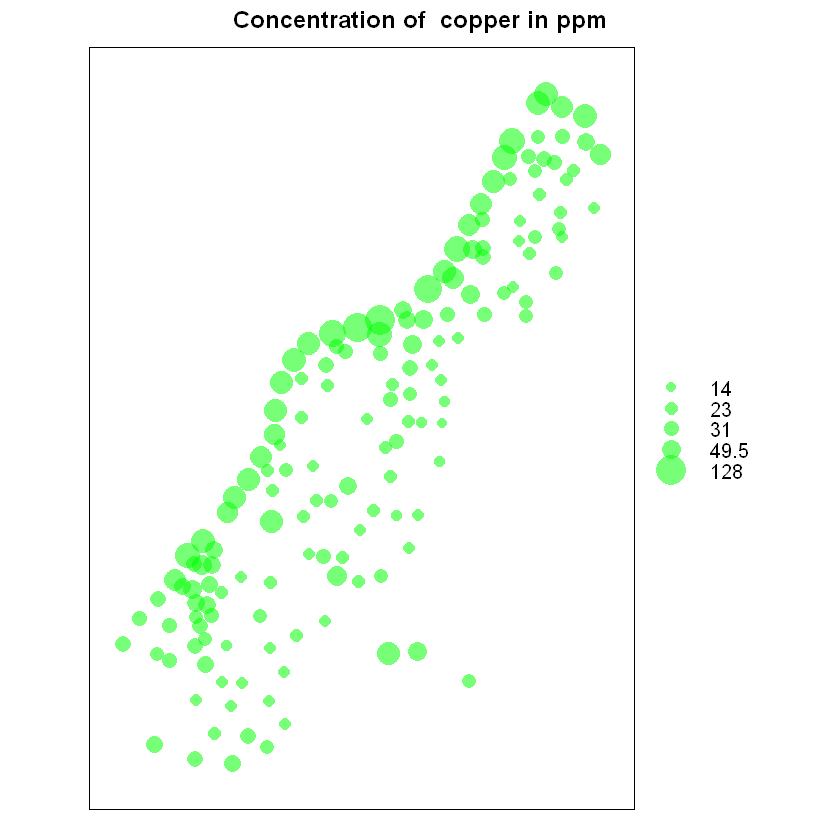

[[1]]

[[2]]

[[3]]

[[4]]


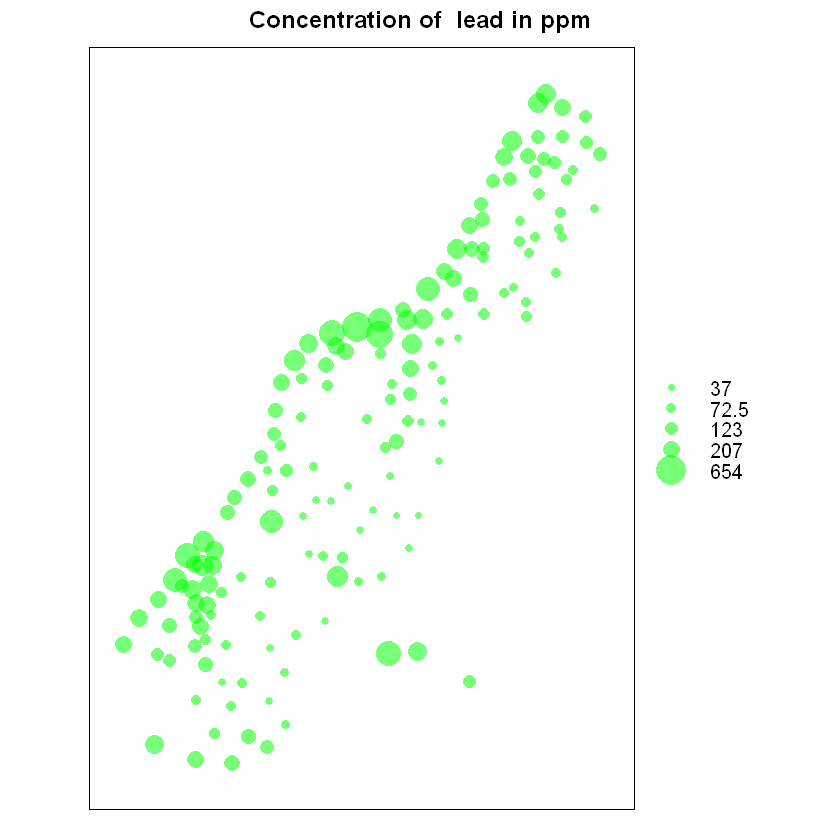

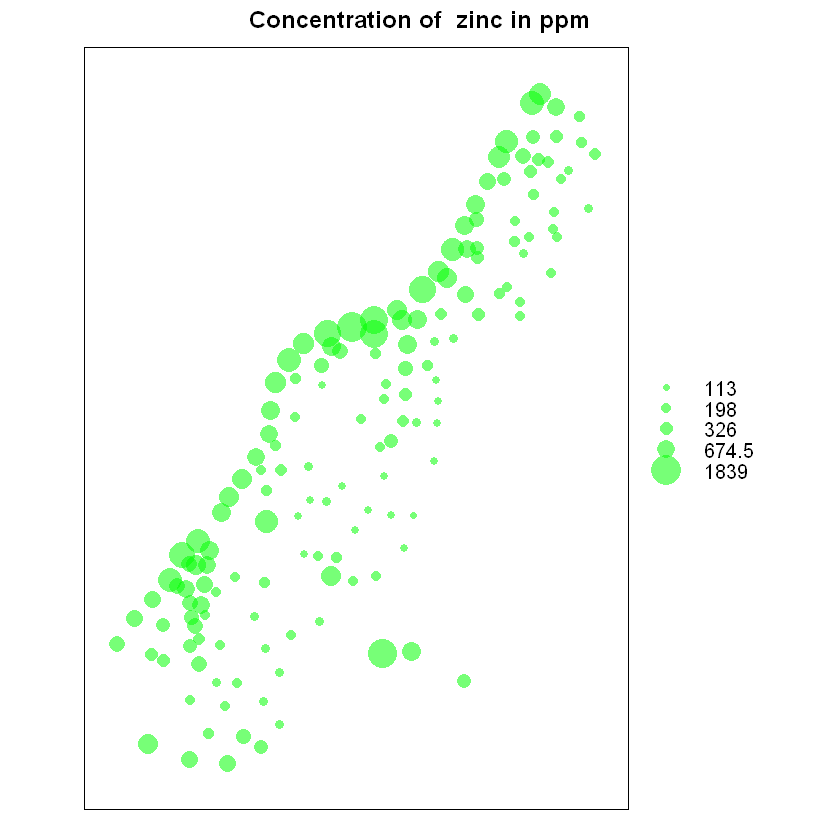

In [36]:
cols = c('cadmium', 'copper', 'lead', 'zinc')
plot.bubble = function(x){
  Title = paste('Concentration of ', x, 'in ppm')
  bubble(meuse, x,col=c("#00ff0088", "#00ff0088"), main = Title)
}
par(mar = c(0.7,0.7,0.7,0.7))
lapply(cols, plot.bubble)

Examine these plots noticing the following:

- The distribution of sample points is far from uniform in space. The densist sampling occurs along the path of the Meuse River, running from the upper right to the lower left of the diagram.
- The distribution of metal concentration is not uniform in space. The highest concentration occurs along the path of the Meuse River. This seems reasonable, since the metals are likely carried by the river. 

## The Variogram

In spatial statistics,  variogram or **semivariance** is a function describing the degree of spatial dependence of a spatial random field or stochastic process

In the case of a concrete example from the field of gold mining, a variogram will give a measure of how much two samples taken from the mining area will vary in gold percentage depending on the distance between those samples. Samples taken far apart will vary more than samples taken close to each other.

Its formula look like :

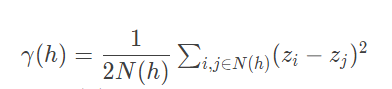


Where N(h) is the number of pairs of observations (i, j) separated by a spatial distance h.
The terms zi and zj are the attribute values of observations i and j respectively.


Next, we will explore the spatial dependency structure of the metal concentarion using variogram methods. 

It appears from the maps that the greatest concentration of the metal pollutants is near the river. Therefore, we will use the distance from the river, in the **dist** column, to compute spatial dependency. 

We will try to use a linear model between dist and metal concentration properties in order to build the variogram

Using of linear model is not mandatory.

For the rest, we will use copper concentration property

As a first step we will plot the concentration of copper versus the distance from the river, by executing the code in the cell below. 

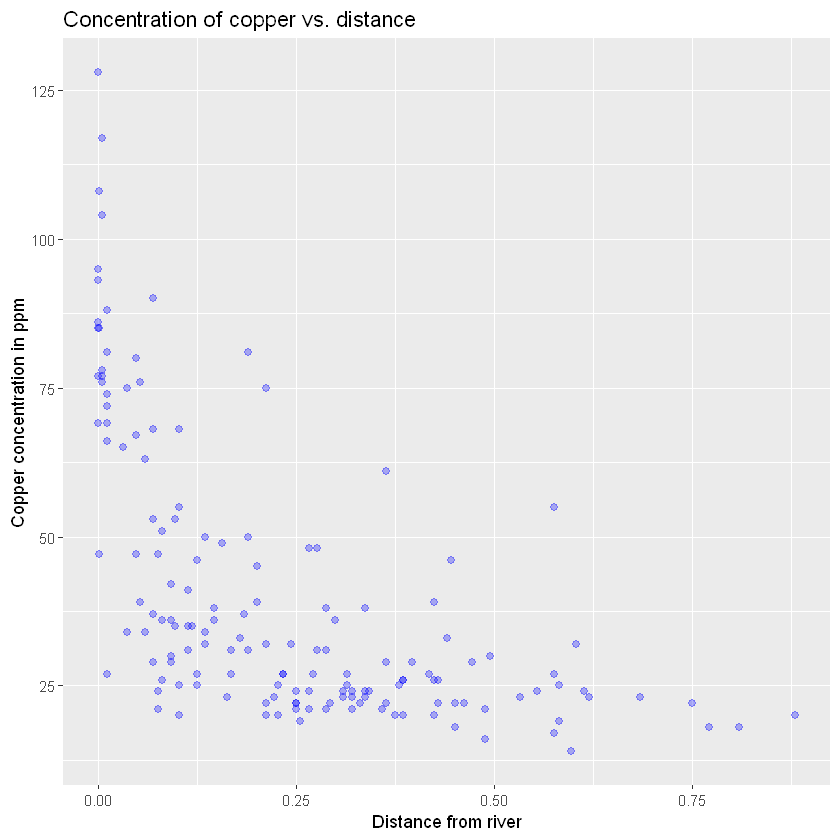

In [37]:
require(ggplot2)
ggplot(data.frame(meuse), aes(dist, copper)) + 
  geom_point(size = 2, color = 'blue', alpha = 0.3)+
  ggtitle('Concentration of copper vs. distance') +
  ylab('Copper concentration in ppm') +
  xlab('Distance from river')

Examine these data. The relationship between copper concentration and distance from the river is far from linear. 

As a next step in this exploration, plot log of copper concentration vs distance to the river by executing the code in the cell below. 

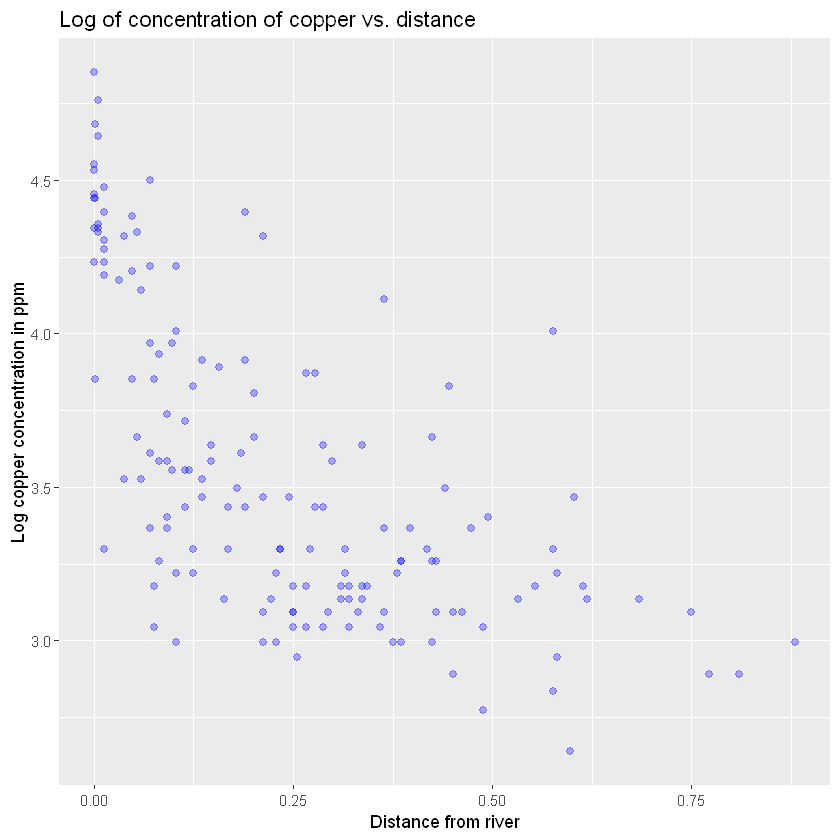

In [38]:
library(ggplot2)
meuse$logCopper = log(meuse$copper)
ggplot(data.frame(meuse), aes(dist, logCopper)) + 
  geom_point(size = 2, color = 'blue', alpha = 0.3) +
  ggtitle('Log of concentration of copper vs. distance') +
  ylab('Log copper concentration in ppm') +
  xlab('Distance from river')

The relationship between log of copper concentration versus distance from the river looks closer to linear. However, this relationship is still not linear.

Next, try plotting log of copper concentration versus the square root of distance from the river by executing the code in the cell below. 

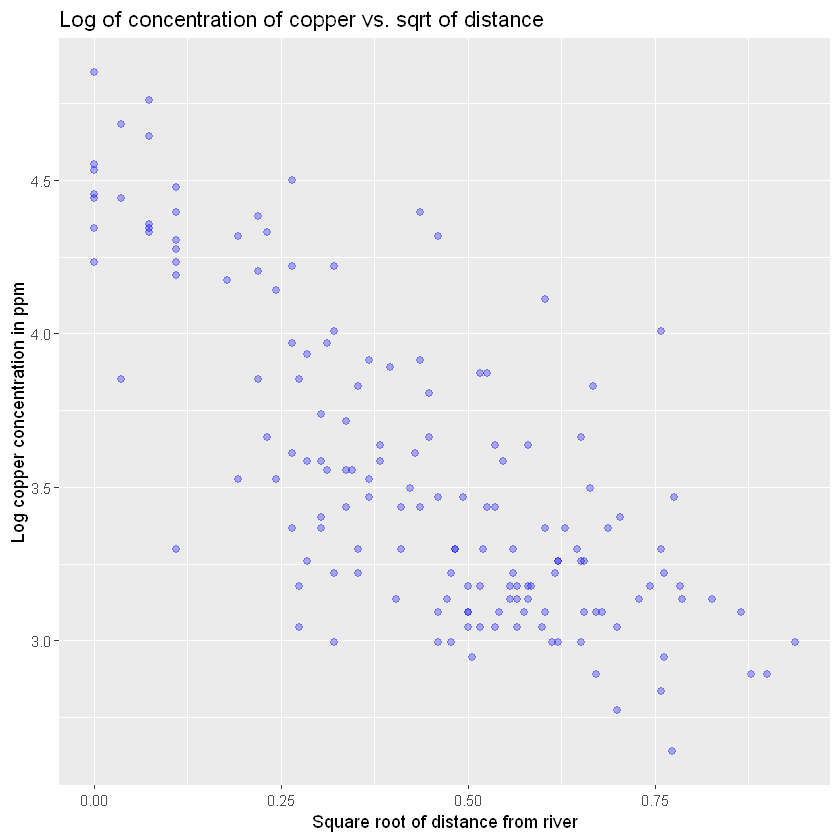

In [39]:
meuse$sqrtDist = sqrt(meuse$dist)
ggplot(data.frame(meuse), aes(sqrtDist, logCopper)) + 
  geom_point(size = 2, color = 'blue', alpha = 0.3)+
  ggtitle('Log of concentration of copper vs. sqrt of distance') +
  ylab('Log copper concentration in ppm') +
  xlab('Square root of distance from river')

Examine the plot shown above. The relationship between log of copper concentration and square root of distance from the river is close to linear. 

Having established a relationship between copper concentration and distance from the river we are now ready to compute the variogram. The code in the cell below computes a variogram model and fits it to the data. Execute this code. 

(**Note**: If an error occurs stating that variogram can't be found, save the notebook, halt and close it, reopen it, run all the cells above this one, and then re-run the cell below - occasionally newly installed packages fail to load in a timely fashion) 

In [40]:
#install.packages('gstat')
require(gstat)
copper.vgm = variogram(logCopper ~ sqrtDist, meuse)
copper.vgm.fit = fit.variogram(copper.vgm, model = vgm(1, "Sph", 900, 1))
head(copper.vgm, 20)
head(copper.vgm.fit, 20)

np,dist,gamma,dir.hor,dir.ver,id
57,79.29244,0.06173480,0,0,var1
299,163.97367,0.08101981,0,0,var1
419,267.36483,0.09121654,0,0,var1
457,372.73542,0.10624012,0,0,var1
547,478.47670,0.10630291,0,0,var1
533,585.34058,0.10435045,0,0,var1
574,693.14526,0.11834666,0,0,var1
564,796.18365,0.12947315,0,0,var1
589,903.14650,0.11786203,0,0,var1
543,1011.29177,0.12422315,0,0,var1


model,psill,range,kappa,ang1,ang2,ang3,anis1,anis2
Nug,0.05030840,0.0000,0.0,0,0,0,1,1
Sph,0.06431828,556.2405,0.5,0,0,0,1,1


Now, plot the variogram to get a feel for its behavior by executing the code in the cell below.

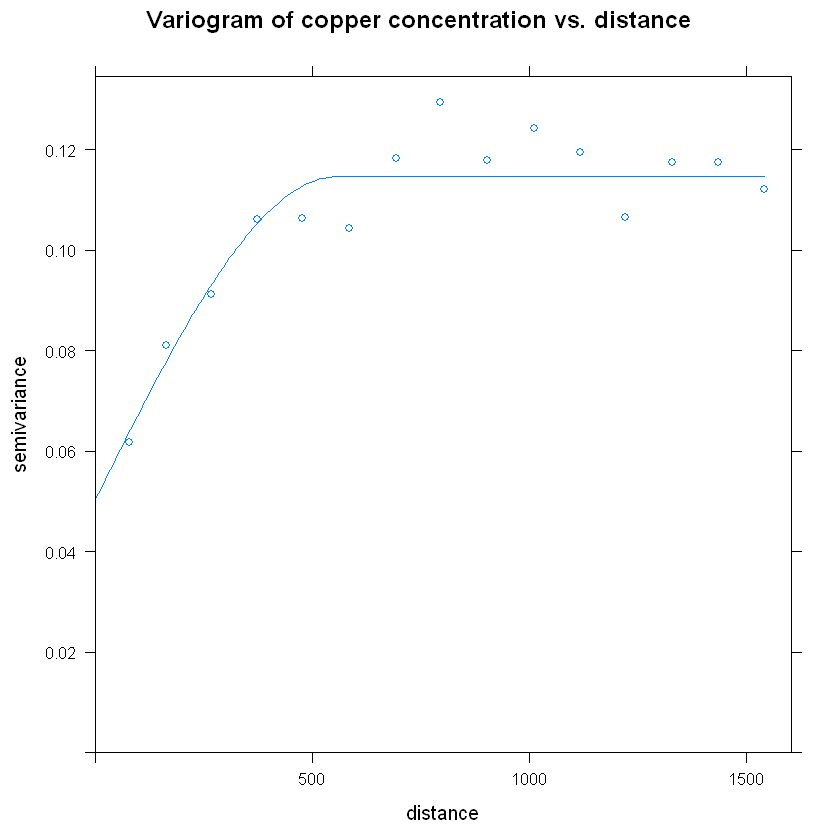

In [41]:
plot(copper.vgm, copper.vgm.fit, main = "Variogram of copper concentration vs. distance")

Examine this plot. The variogram versus distance relationship shows a reasonably good fit. 
Notice that variogram  value start at around 0.05 (named nugget) on y axis , increases rapidly on x axis up to about 500 meters (named range)  and then levels out thereafter around 0.11 on y axis (named sill). 


### Variogram at differents angles

The variogram was computed using orthoginal distance from the river. However, there can be a dependancy structure in spatial at any direction. To investigate this relationship, execute the code in the cell below. 

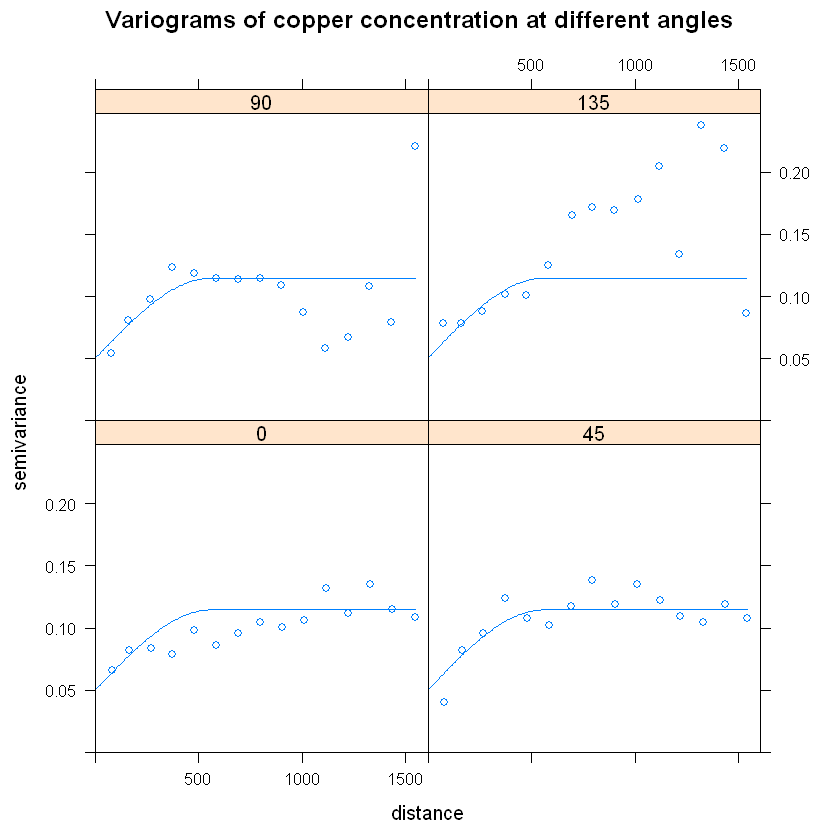

In [42]:
copper.vgm.dir = variogram(logCopper ~ sqrtDist, meuse, alpha = c(0, 45, 90, 135))
plot(copper.vgm.dir, copper.vgm.fit, main = 'Variograms of copper concentration at different angles')

Examine the plots of the semivariance versus distance at the angles of 0, 45, 90 and 135 degrees. Notice that the fit is good at 0 and 45 degrees. The fit at 90 and 135 degrees is not particularly good.


## Variogram maps

Another means of looking at directional dependence in semivariograms is obtained by looking at variogram maps. Instead of classifying point pairs Z(s)
and Z(s + h) by direction and distance class separately, we can classify them
jointly. If h = {x, y} be the two-dimentional coordinates of the separation
vector, in the variogram map the semivariance contribution of each point pair
(Z(s) − Z(s + h))2
is attributed to the grid cell in which h lies. The map is
centered around (0, 0), as h is geographical distance rather than geographical
location. Cutoff and width correspond to some extent to map extent and cell
size; the semivariance map is point symmetric around (0, 0), as γ(h) = γ(−h).

Having computed and examined the variogram, we will now make a map of the variogram. the code in the cell below computes a variogram with the **map = TRUE** argument. Execute the code in the cell below to display the map.



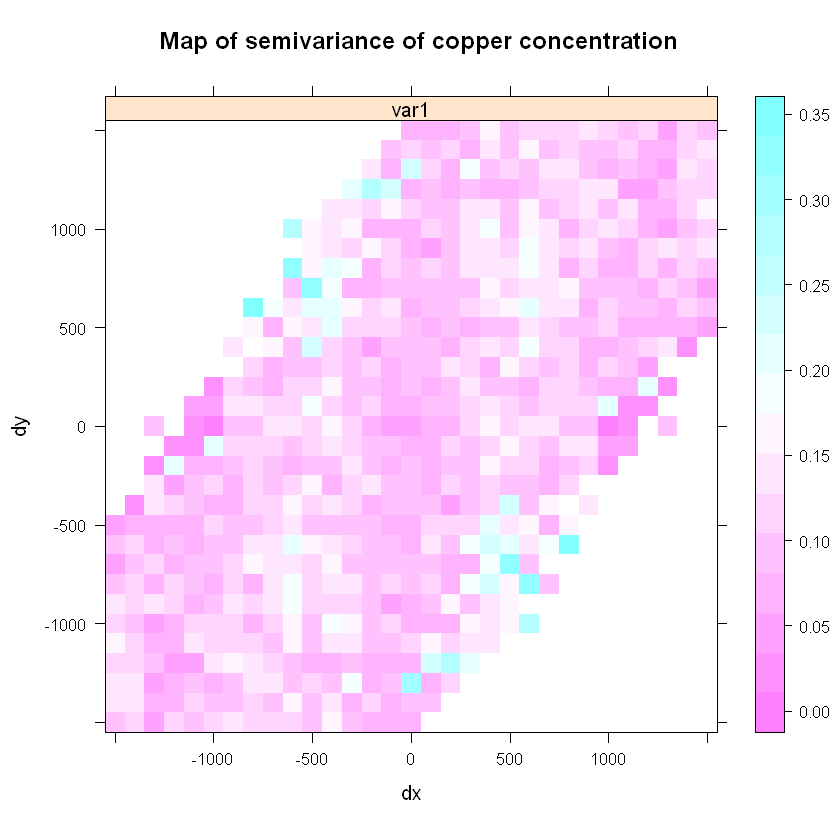

In [43]:
copper.vgm.map = variogram(logCopper ~ sqrtDist, meuse, cutoff = 1500, width = 100, map = TRUE)
plot(copper.vgm.map, threshold = 5, main = "Map of semivariance of copper concentration")

Examine this map. Most of the map is dominated by areas of low semivariance with just a few areas of high semivariace.  

## Interpolate the Copper Concentration using krigging


In statistics, originally in geostatistics, **kriging**, also known as Gaussian process regression, is a method of interpolation based on Gaussian process governed by prior covariances.

Kriging include Simple, Ordinary or Universal, global or local, Point or Block Kriging.

Having computed and evaluated the variogram, we will now interpolate the values of copper concentration. we will use first the kriging method to interpolate the irregularly sampled copper concentration to a regular grid.  


As a first step, we will create a map of the grid used for interpolation. More specifically, we will create an image showing distance from the river on the grid. Execute the code in the cell below to view this map. 



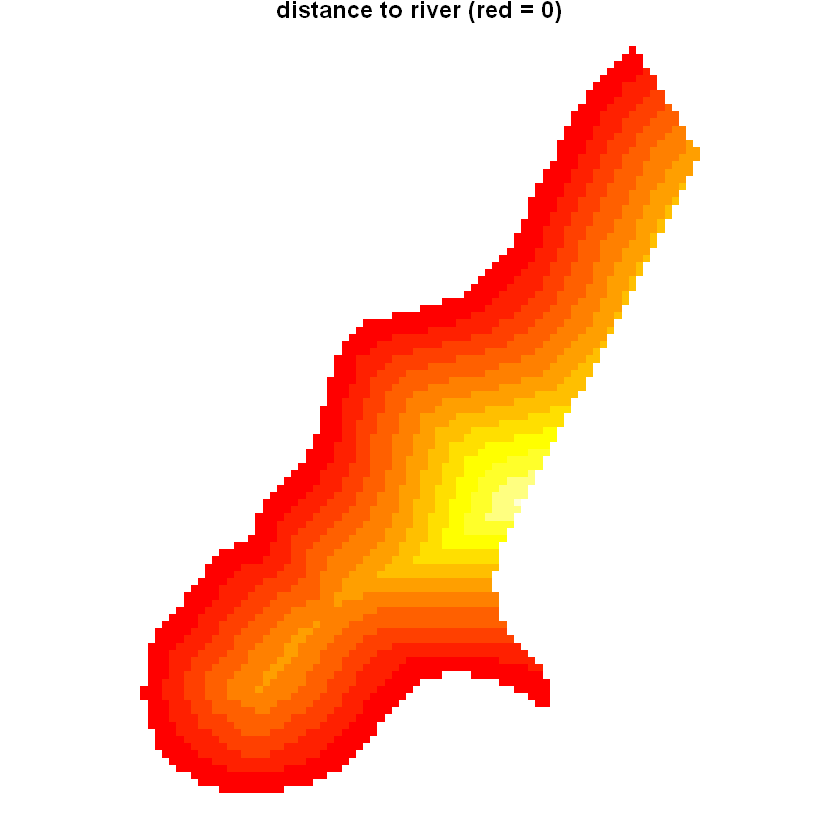

In [19]:
par(mar = c(0.7,0.7,0.7,0.7))
image(meuse.grid["dist"])
title("distance to river (red = 0)")

The Meuse River runs from the upper right to the lower left of the diagram, curves toward the upper right, and finally toward the lower right. Examine this map and note that, as expected, the lowest distance is near the curve of the river and the greatest distances are near the center (shown in yellow). 

Next, using the distance on the grid we will use the **iwd** function to compute the inverse weighted distance of copper concentration. Execute the code in the cell below to compute the IWD of copper concentration. 

In [45]:
install.packages("geojsonio")
copper.idw = idw(copper ~ 1, meuse, meuse.grid)
names(copper.idw)
head(copper.idw)

Installing package into 'C:/Users/mamadi.fofana/OneDrive - AngloGold Ashanti/Documents/R/win-library/3.6'
(as 'lib' is unspecified)


package 'geojsonio' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\mamadi.fofana\AppData\Local\Temp\RtmpCabyxG\downloaded_packages
[inverse distance weighted interpolation]


[1] "var1.pred" "var1.var"

Warning message in CPL_crs_from_input(x):
"GDAL Error 1: PROJ: proj_create: Non numerical value in towgs84 clause"ERROR while rich displaying an object: Error in st_crs.character(x@projargs): invalid crs: +proj=stere
  +lat_0=52.15616055555555 +lon_0=5.38763888888889
 +k=0.999908 +x_0=155000 +y_0=463000
 +ellps=bessel +units=m +no_defs
 +towgs84=565.2369,50.0087,465.658,
 -0.406857330322398,0.350732676542563,-1.8703473836068, 4.0812

Traceback:
1. FUN(X[[i]], ...)
2. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
3. tryCatchList(expr, classes, parentenv, handlers)
4. tryCatchOne(expr, names, parentenv, handlers[[1L]])
5. doTryCatch(return(expr), name, parentenv, handler)
6. withCallingHandlers({
 .   

Object of class SpatialPixelsDataFrame
Object of class SpatialPixels
Grid topology:
  cellcentre.offset cellsize cells.dim
x            178460       40        78
y            329620       40       104
SpatialPoints:
       x      y
1 181180 333740
2 181140 333700
3 181180 333700
4 181220 333700
5 181100 333660
6 181140 333660
Coordinate Reference System (CRS) arguments: +proj=stere
+lat_0=52.15616055555555 +lon_0=5.38763888888889 +k=0.999908
+x_0=155000 +y_0=463000 +ellps=bessel +units=m +no_defs
+towgs84=565.2369,50.0087,465.658,
-0.406857330322398,0.350732676542563,-1.8703473836068, 4.0812 

Data summary:
   var1.pred        var1.var  
 Min.   :59.87   Min.   : NA  
 1st Qu.:60.55   1st Qu.: NA  
 Median :63.43   Median : NA  
 Mean   :64.73   Mean   :NaN  
 3rd Qu.:67.23   3rd Qu.: NA  
 Max.   :73.59   Max.   : NA  
                 NA's   :6    

Notice that the result has two columns. One showing the IWD and the other showing the variance of the computed IWD. 

We will now create a map of the IWD of the copper concentration by executing the code in the cell below.  

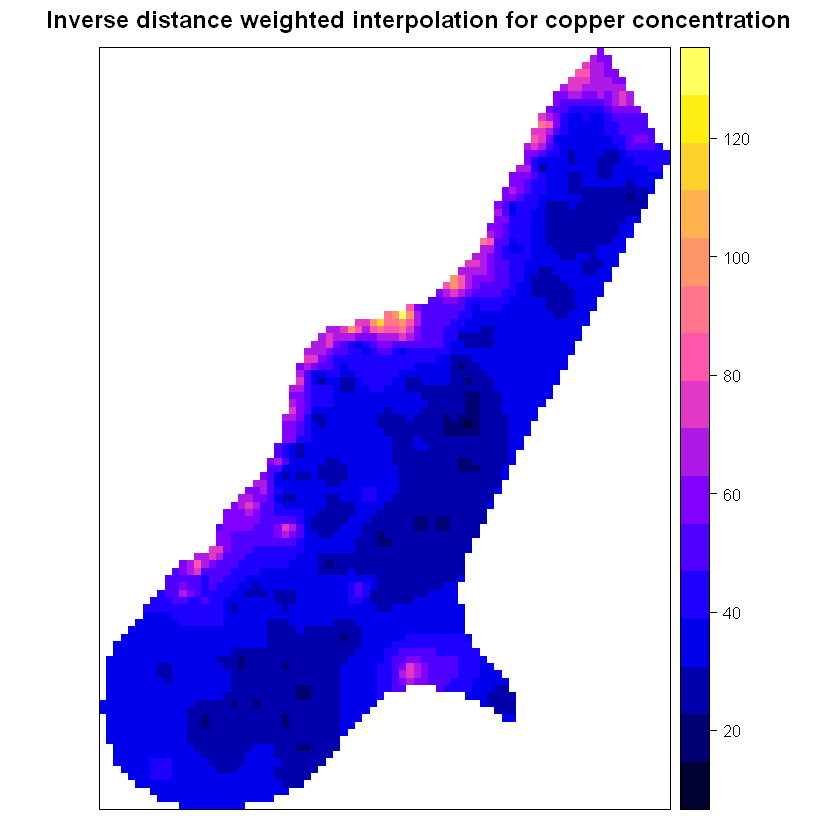

In [28]:
par(mar = c(0.7,0.7,0.7,0.7))
spplot(copper.idw["var1.pred"], main = "Inverse distance weighted interpolation for copper concentration")

Examine this map. Notice that the IWD of copper concentration has a few hot spots (high values) along the path of the river. There are areas of low IWD farther from the river. While this map provides some interesting insights into spatial distribution of copper pollution, it does not represent an interpolation.

To interpolate the concentration of log of copper onto the grid we will use the kriging method. Kriging used the spatial dependency structure of the variogram we computed perviously. Execute the code in the cell below to compute the kriged concentration of copper and plot it on a map. 

[using ordinary kriging]


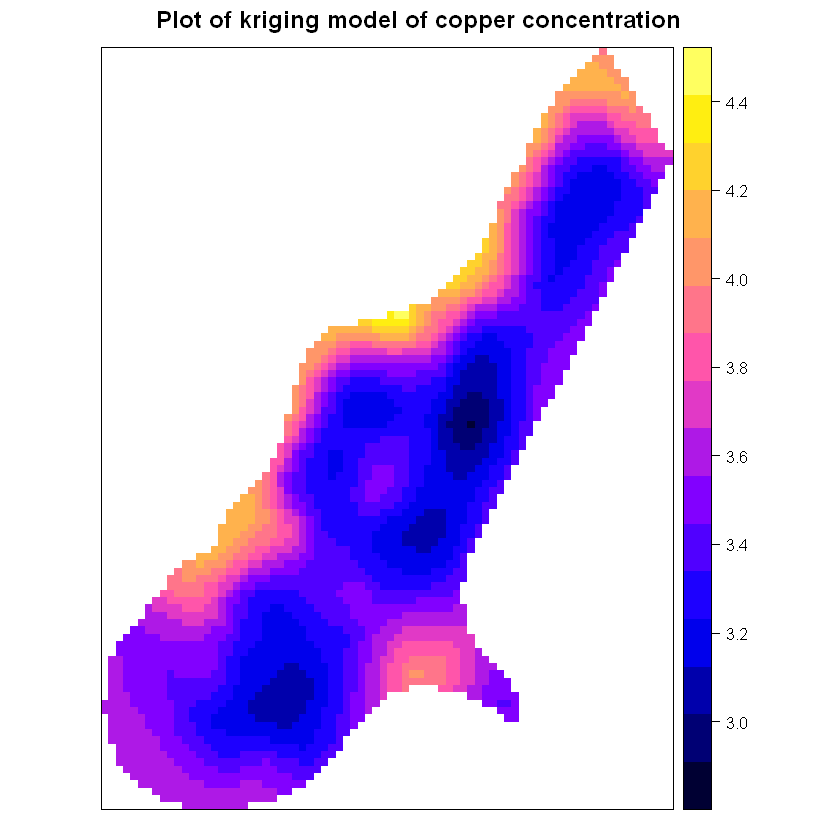

In [24]:
copper.kriged = krige(logCopper ~ 1, meuse, meuse.grid, model = copper.vgm.fit)
spplot(copper.kriged["var1.pred"], main ="Plot of kriging model of copper concentration")

Examine the map of kriged copper concentration. As expected, the highest concentrations of copper polution are near the Meuse River. There are areas of low concentration in areas far from the river.  

## Interpolate the Copper Concentration using  Conditional simulation

Simulation is broadly defined as the process of replicating reality using a model. 
In geostatistics, simulation is the realization of a random function (surface) that has the same statistical features as the sample data used to generate it (measured by the mean, variance, and semivariogram). Gaussian geostatistical simulation (GGS), more specifically, is suitable for continuous data and assumes that the data, or a transformation of the data, has a normal (Gaussian) distribution. The main assumption behind GGS is that the data is stationary—the mean, variance, and spatial structure (semivariogram) do not change over the spatial domain of the data. Another key assumption of GGS is that the random function being modeled is a multivariate Gaussian random function.

GGS offers an advantage over kriging. Because kriging is based on a local average of the data, it produces smoothed output. GGS, on the other hand, produces better representations of the local variability because it adds the local variability that is lost in kriging back into the surfaces it generates


The Gaussian Geostatistical Simulations allows two types of simulation:
-	Conditional simulation honors the data values (unless measurement error has been included in the kriging model). Some differences between measured and simulated values for sample locations may occur because simulation generates values at grid cell centers, which may not correspond exactly to the location of the sample points. Conditional simulation also replicates the mean, variance, and semivariogram of the data, on average (that is, averaged over many realizations). The simulated surfaces look like kriging prediction maps but show more spatial variability.
-	Unconditional simulation does not honor the data values, but does replicate the data's mean, variance, and semivariogram (on average). The simulated surfaces show spatial structure that is similar to a kriged map, but high- and low-value areas will not necessarily occur where high- and low-data values exist in the input data.

gstat package can use sequential Gaussian or indicator simulation and   conditional or unconditional simulation


drawing 4 GLS realisations of beta...
[using conditional Gaussian simulation]


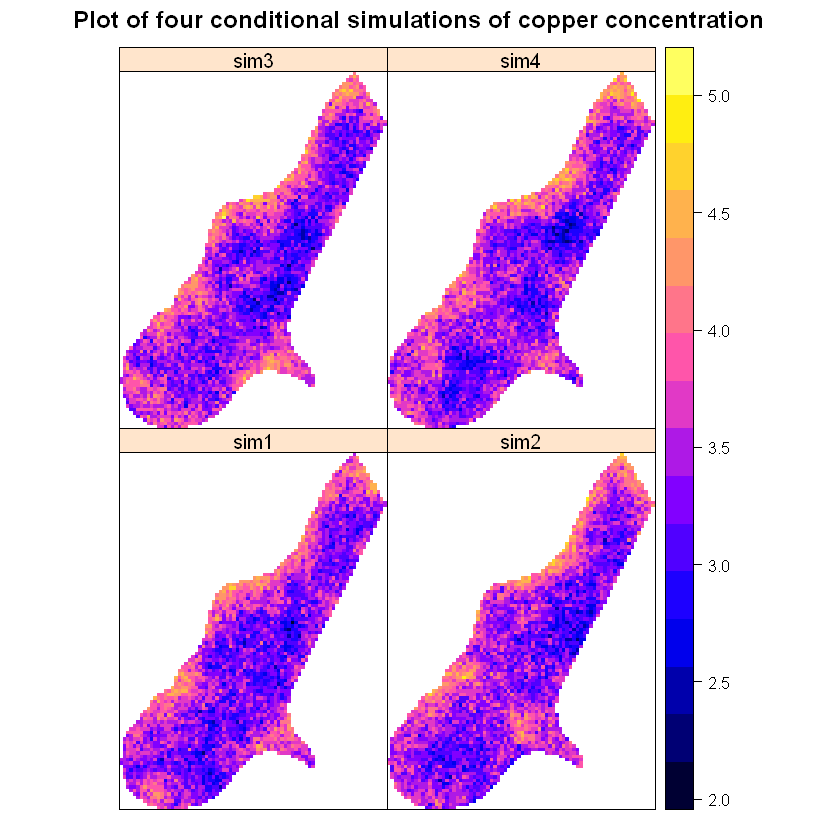

In [27]:
#lzn.condsim = krige(log(zinc)~1, meuse, meuse.grid, model = lzn.fit,
#+ nmax = 30, nsim = 4)

copper.kriged = krige(logCopper ~ 1, meuse, meuse.grid, model = copper.vgm.fit, nmax = 30, nsim = 4)
spplot(copper.kriged, main ="Plot of four conditional simulations of copper concentration")


## Summary

In this tutorial we have done the following:

- Examined properties of the SpatialPixelsDataFrame.
- Mapped spatially sampled data.
- Determined the variogram structure of spatial data.
- Interpolated the spatail data values using kriging and simulation. 